In [1]:
from timeit import default_timer as timer
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel,ConstantKernel as C
import random 

In [2]:
def f(data,L1,L2):
    """The function to predict."""
    x=np.atleast_2d(L1*np.sin(data[:,0]) * np.sin(data[:,1]))
    y=np.atleast_2d(-L1*np.sin(data[:,0]) * np.cos(data[:,1]))
    z=np.atleast_2d(L1*np.cos(data[:,0]) + L2)
    return x,y,z #row array

def getData(batch_num,batch_size):
    data=np.zeros((batch_num*batch_size,2))
    for i in range(batch_num):
        data[(i)*batch_size:(i+1)*batch_size,0]=np.linspace(0,2*np.pi,batch_num)[i]
        data[(i)*batch_size:(i+1)*batch_size,1]=np.linspace(0,2*np.pi,batch_size)
    return data # data size=(batch_num*batch_size)x2

def plot2d(num_samples_start,num_samples_end,pred,train_data_in,train_data_out,test_data_out,sigma,div,train_num,pos):
    
    A=train_data_in[train_data_in>=num_samples_start]
    B=train_data_in[train_data_in<=num_samples_end]
    choice_to_plot = [val for val in B if val in A]
   
    train_to_plot=[]
    for i,val in enumerate(train_data_in):
        if val in choice_to_plot:
            train_to_plot.append(i)
    
    plt.figure(figsize=(16,6))
    
    up=pred.ravel() + 1.96*sigma
    down=pred.ravel() - 1.96*sigma
    plt.plot(np.array(range(num_samples_end-num_samples_start))+num_samples_start, down[num_samples_start:num_samples_end], "g:")
    plt.plot(np.array(range(num_samples_end-num_samples_start))+num_samples_start, up[num_samples_start:num_samples_end], "g:")
    plt.fill_between(np.array(range(num_samples_end-num_samples_start))+num_samples_start,down[num_samples_start:num_samples_end],up[num_samples_start:num_samples_end], color="lightgrey",label='95% confidence interval') # 95% confidence
    plt.plot(np.array(range(num_samples_end-num_samples_start))+num_samples_start, test_data_out.ravel()[num_samples_start:num_samples_end],'r',linewidth=1,label='real value of position {}'.format(pos))
    plt.plot(np.array(range(num_samples_end-num_samples_start))+num_samples_start, pred.ravel()[num_samples_start:num_samples_end], 'b',linewidth=1.0,label='mean prediction value of position {}'.format(pos))
    plt.scatter(choice_to_plot,train_data_out.ravel()[train_to_plot], c='black',s=20,label='training points')
   
    
    plt.xlabel("smaple number")
    plt.ylabel("position of {}".format(pos))
    plt.title("noise level σ = {}, {} traing samples".format(div,train_num))
    plt.legend()
    plt.tight_layout()
    plt.show()

In [12]:
def GPR(L1,L2,div,test_batch_num,test_batch_size,train_num,n_restarts_optimizer):
    div2 = 0.005
   
    #get test data
    test_data_in = getData(test_batch_num,test_batch_size)
    test_data_out_x,test_data_out_y,test_data_out_z=f(test_data_in,L1,L2)
    test_data_out_x +=np.random.normal(0, div2,np.size(test_data_out_x,axis=1))
    test_data_out_y +=np.random.normal(0, div2,np.size(test_data_out_y,axis=1))
    test_data_out_z +=np.random.normal(0, div2,np.size(test_data_out_z,axis=1))

    # get training data
    choice = np.array(range(train_num))*int((test_batch_num*test_batch_size)/train_num)
    train_data_in=test_data_in[choice,:]
    train_data_out_x=np.atleast_2d(test_data_out_x[0,choice])
    train_data_out_y=np.atleast_2d(test_data_out_y[0,choice])
    train_data_out_z=np.atleast_2d(test_data_out_z[0,choice])
    
    
    #run GPR 
    start = timer()
    kernel =  C(1, (1e-7, 1e3))*RBF(1 ,(1e-5, 100000.0))
    if div==0:
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer =n_restarts_optimizer)
    else:
        gp = GaussianProcessRegressor(kernel=kernel, alpha=div**2,n_restarts_optimizer =n_restarts_optimizer)
    # Fit to data z
    gp.fit(train_data_in, train_data_out_z.T)
    # Make the prediction z
    z_pred, sigma_z = gp.predict(test_data_in, return_std=True)
    # Fit to data y
    gp.fit(train_data_in, train_data_out_y.T)
    # Make the prediction y
    y_pred, sigma_y = gp.predict(test_data_in, return_std=True)
    # Fit to data x
    gp.fit(train_data_in, train_data_out_x.T)
    # Make the prediction x
    x_pred, sigma_x = gp.predict(test_data_in, return_std=True)
    end =  timer()
    print("The time elapsed：%f second(s)"%(end - start))
    #plot prediction of z position
    print('the mean error of position {} is {}'.format('z',np.mean((test_data_out_z.ravel()-z_pred.ravel()))))
    plot2d(0,test_batch_size*test_batch_num,z_pred,choice,train_data_out_z,test_data_out_z,sigma_z,div,train_num,'z')
    plot2d(0,2*test_batch_size+1,z_pred,choice,train_data_out_z,test_data_out_z,sigma_z,div,train_num,'z')
    #plot prediction of y position
    print('the mean error of position {} is {}'.format('y',np.mean((test_data_out_y.ravel()-y_pred.ravel()))))
    plot2d(0,test_batch_size*test_batch_num,y_pred,choice,train_data_out_y,test_data_out_y,sigma_y,div,train_num,'y')
    plot2d(0,2*test_batch_size+1,y_pred,choice,train_data_out_y,test_data_out_y,sigma_y,div,train_num,'y')
    #plot prediction of x position
    print('the mean error of position {} is {}'.format('x',np.mean((test_data_out_x.ravel()-x_pred.ravel()))))
    plot2d(0,test_batch_size*test_batch_num,x_pred,choice,train_data_out_x,test_data_out_x,sigma_x,div,train_num,'x')
    plot2d(0,2*test_batch_size+1,x_pred,choice,train_data_out_x,test_data_out_x,sigma_x,div,train_num,'x')
    
    print('the max value of position {} is {}'.format('x',np.max(x_pred)))
    print('the min value of position {} is {}'.format('x',np.min(x_pred)))
    print('the max value of position {} is {}'.format('y',np.max(y_pred)))
    print('the min value of position {} is {}'.format('y',np.min(y_pred)))
    print('the max value of position {} is {}'.format('z',np.max(z_pred)))
    print('the min value of position {} is {}'.format('z',np.min(z_pred)))
  

The time elapsed：24.916686 second(s)
the mean error of position z is -0.0003280076282248596


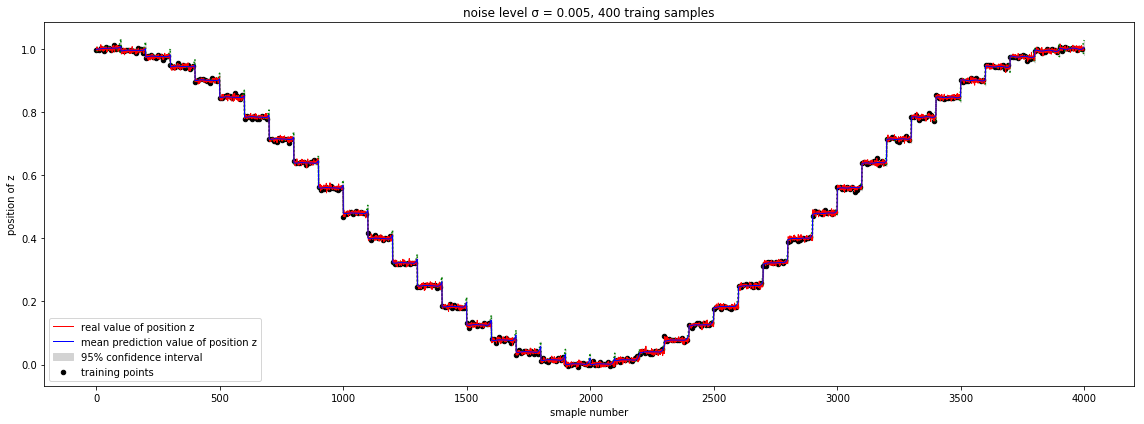

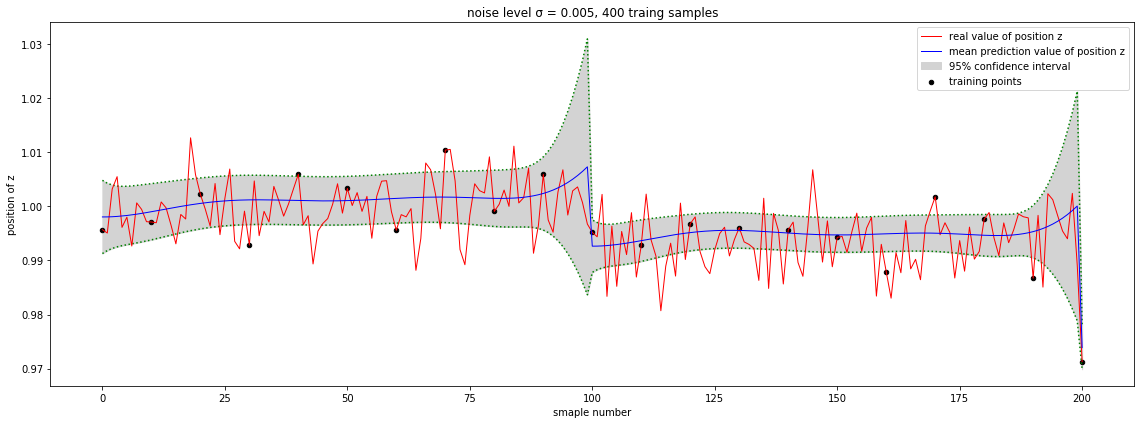

the mean error of position y is -0.0001208977405526806


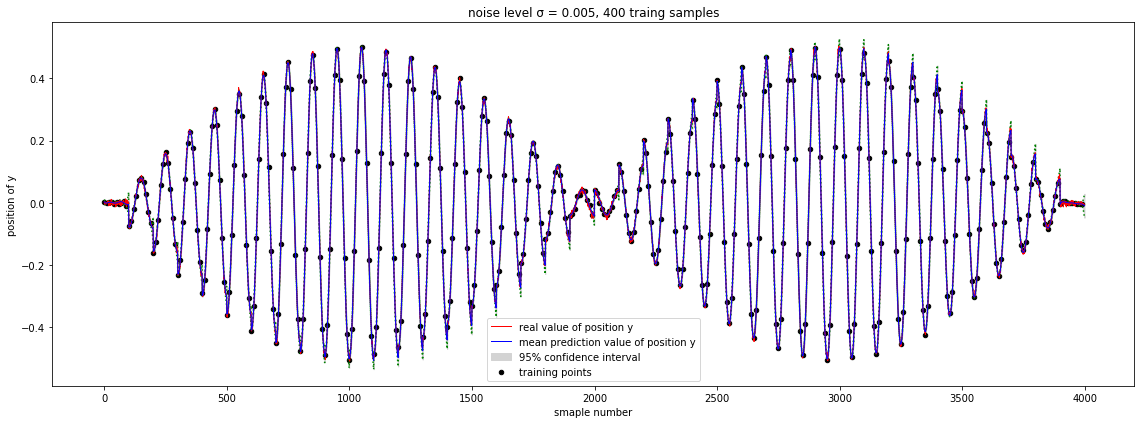

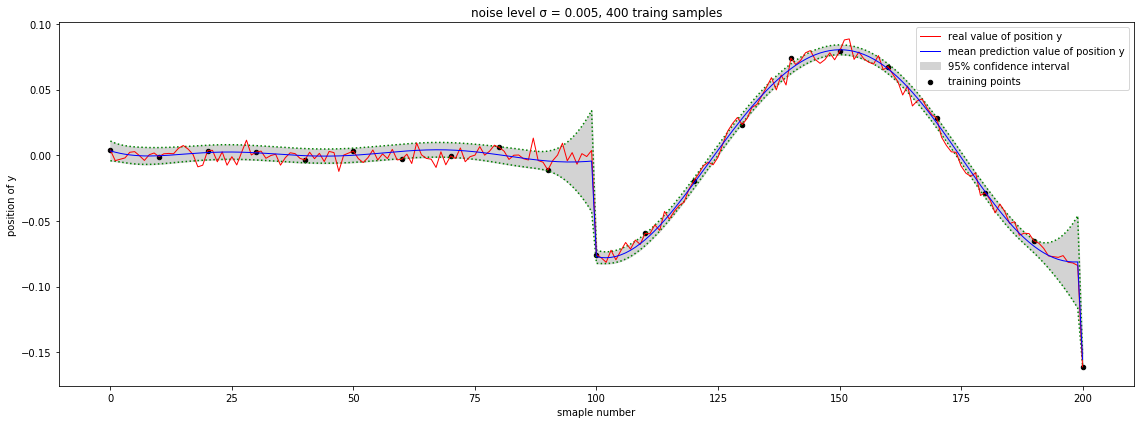

the mean error of position x is -0.00010974439274979495


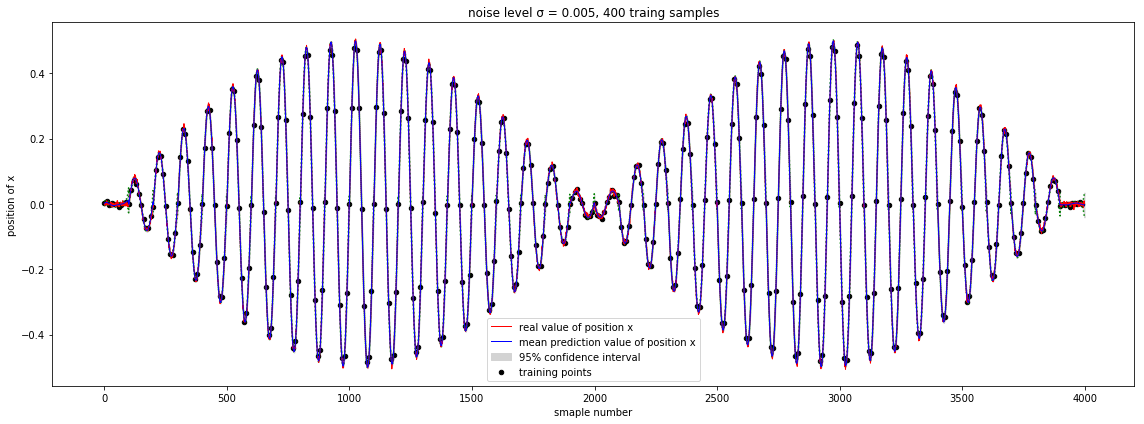

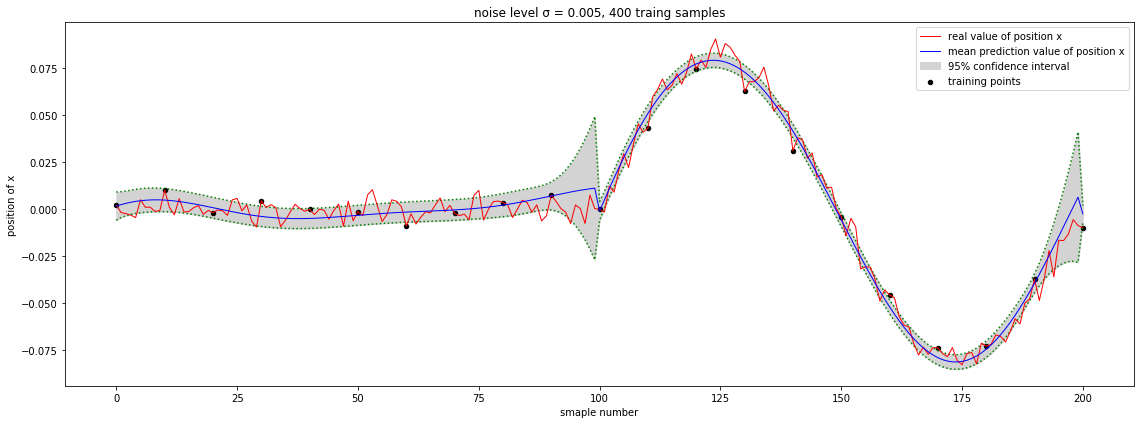

the max value of position x is 0.4995887892123392
the min value of position x is -0.5001610703016013
the max value of position y is 0.5011656003475764
the min value of position y is -0.5055266247858299
the max value of position z is 1.007317643395936
the min value of position z is -0.00023675382260535116


In [13]:
GPR(0.5,0.5,0.005,40,100,400,20)

The time elapsed：26.194830 second(s)
the mean error of position z is 0.051889193968476646


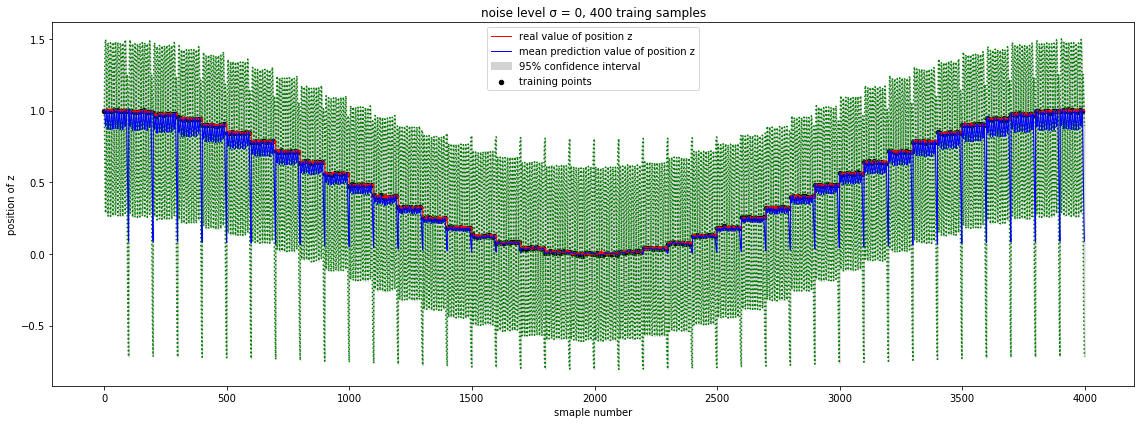

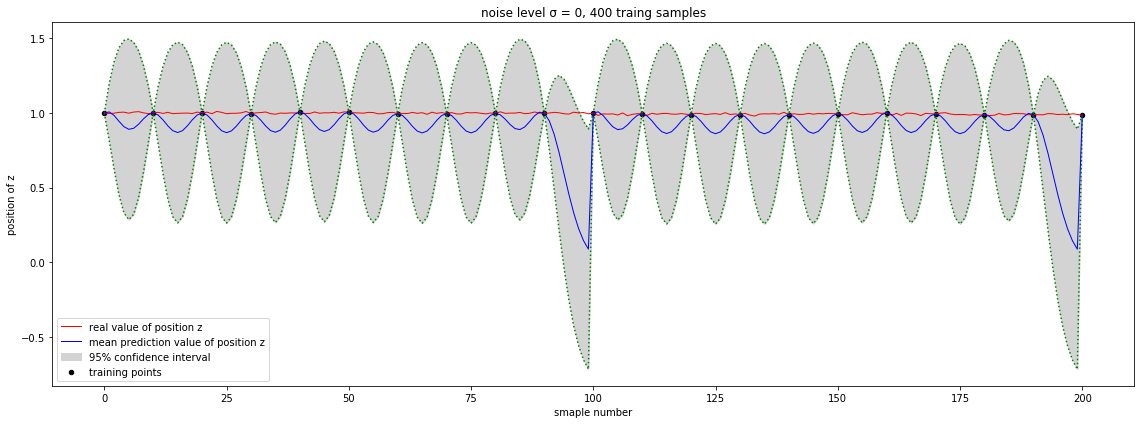

the mean error of position y is -4.5436724554118516e-05


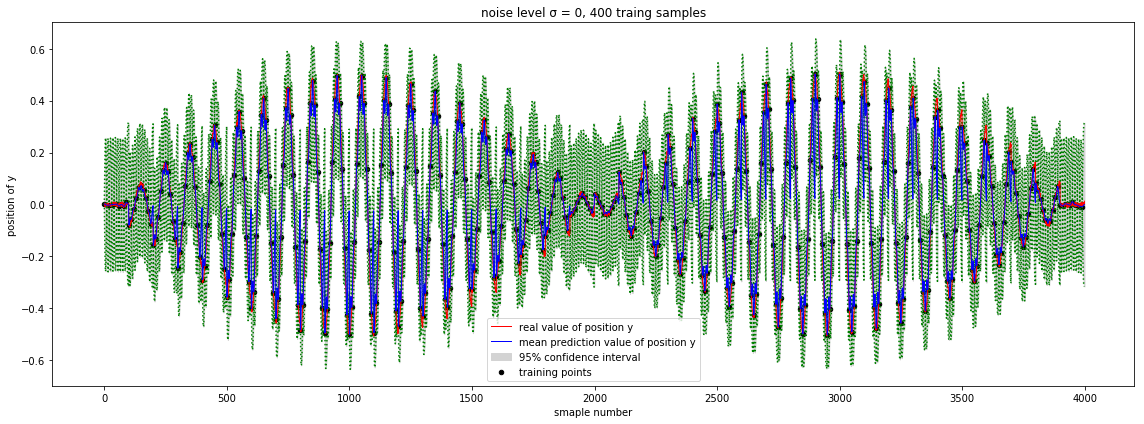

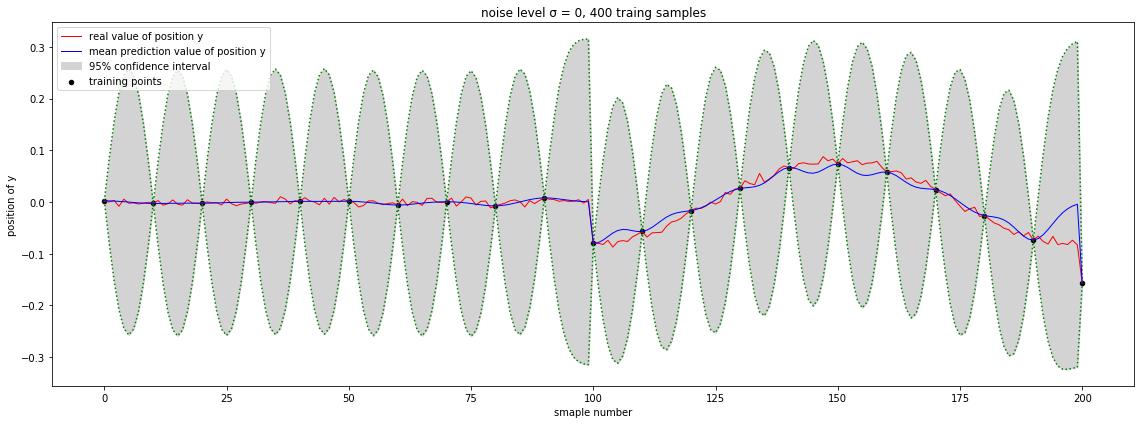

the mean error of position x is -0.00019583918525831735


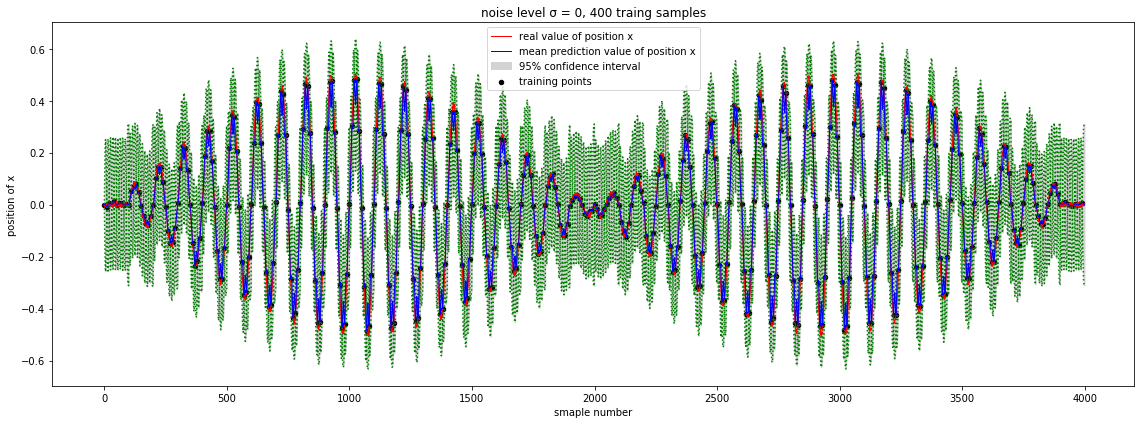

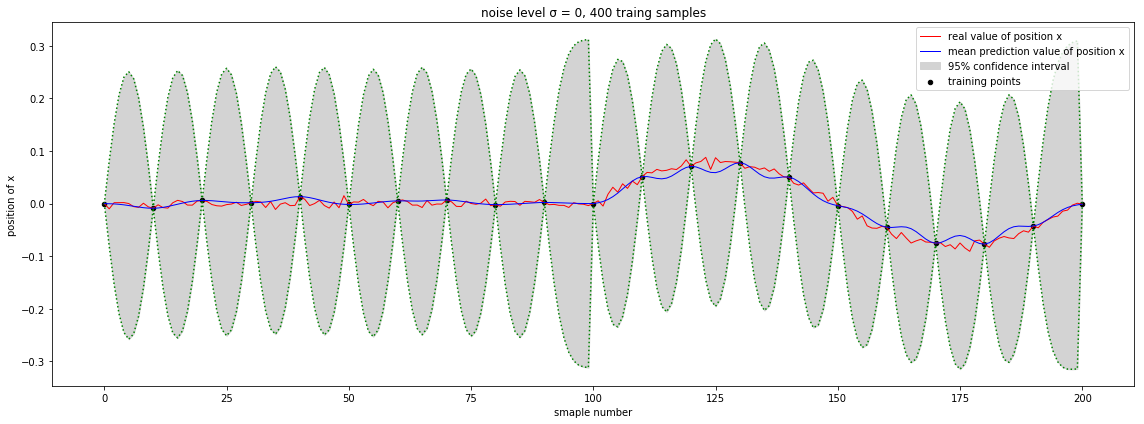

the max value of position x is 0.48334010095743807
the min value of position x is -0.4860559145858776
the max value of position y is 0.5028841521140235
the min value of position y is -0.5018909634084672
the max value of position z is 1.0088361362876994
the min value of position z is -0.012144772281345695


In [14]:
GPR(0.5,0.5,0,40,100,400,20)